<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn</h1>
</div>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [3]:
import os
import subprocess
from pprint import pprint

In [4]:
import toml
import numpy as np
import matplotlib.pyplot as plt
import h5py
import segyio

In [5]:
# Set numerical precision
# DTYPE = np.float64

In [6]:
# Imports for Cervino
from cervino import *

<div class="alert alert-info">
    <h2>Cervino setup</h2>
</div>

General Cervino class which allows one to do most of the work. This class has methods to create the TOML file, the solver input file, to run the simulation, ...

In [7]:
marmousi = Cervino(name='marmousi')

<div class="alert alert-info">
    <h2>General setup</h2>
</div>

In this initial section, we define a few general parameters required by the simulation.

In [8]:
general_dict = get_general_dict(solver='matterhorn',
                                desc='Matterhorn and marmousi')

In [9]:
# pprint(general_dict)

<div class="alert alert-info">
    <h2>Domain setup</h2>
</div>

In this section, we need to define the model used for the simulation. In the example below, we choose the original Marmousi model.

In [10]:
fn_h5 = marmousi_original(bin=True, overwrite=True)

This function will fetch the Marmousi model and prepare it for Cervino. To do so, it will create a directory marmousi_original_model in the current working directory /work/bfilippo/cervino/notebooks.
The existing directory /work/bfilippo/cervino/notebooks/marmousi_original_model has been removed!
The archive marmousi_archive.tar.gz already exists!


In [11]:
domain = AcousticDomain()

In [12]:
# Set the models
domain.set_model_from_hdf5(fn_h5, geometry=False)

In [13]:
# pprint(domain.get_domain_dict())

<div class="alert alert-info">
    <h2>Time and frequency setup</h2>
</div>

Here we need to define the time step in seconds `time_step_in_seconds` and the number of time steps `number_of_timesteps`. In the example below, we first define the time step, initial, and final time, and use these values to compute the number of time steps. However, one could also directly define the number of time steps.

In [99]:
time_step_in_seconds = 1e-4
start_time_in_seconds = 0.0
# time_shift_in_seconds = 1.0
end_time_in_seconds = 0.5

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

In [100]:
# This will also become a function to be consistent with the other sections
time_dict = get_time_dict(ts=time_step_in_seconds, nt=number_of_timesteps)

In [101]:
# pprint(time_dict)

<div class="alert alert-info">
    <h2>Input setup</h2>
</div>

Here, we define the input (sources) which will generate the wavefields. We can define a single point source or an array (boundary) of point sources. In the example below, we define a point source characterised by a Ricker wavelet as source time function.

In [153]:
# Use a Ricker wavelet as source time function
center_frequency = 30.0
stf = RickerWavelet(t, fc=center_frequency, delay=1.5, delay_type='c')

In [166]:
# Define a point source
name = "source0"
location = (4000.0, 0.0, 20.0)
spatial_type = "fz"
scale = 1.

source0 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [155]:
# pprint(source0.get_source_dict())

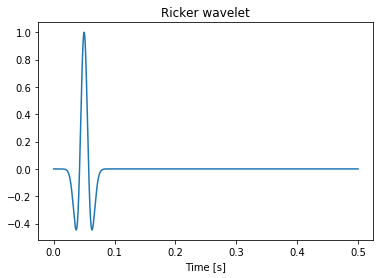

In [156]:
# Plot the source time function
# This will be implemented in the PointSource class
plt.plot(t, source0.stf.wavelet)
_ = plt.title('Ricker wavelet')
_ = plt.xlabel('Time [s]')

Additionally, we can also load a user-defined wavelet from a binary file.

In [164]:
filename = 'user_defined_ricker.bin'
stf = UserWavelet(filename, nt=t.size)

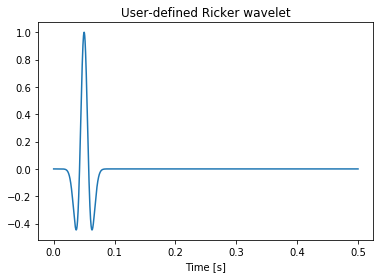

In [165]:
# Plot the source time function
# This will be implemented in the PointSource class
plt.plot(t, stf.wavelet)
_ = plt.title('User-defined Ricker wavelet')
_ = plt.xlabel('Time [s]')

<div class="alert alert-info">
    <h2>Output setup</h2>
</div>

Here, we definte the output of the simulation. Now we create two shot gathers.

In [120]:
# First we create a general gather object
start_timestep = 0
end_timestep = 5000
timestep_increment = 10

gather = ShotGather(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [121]:
n = domain.get_domain_dict()['geometry']['number-of-cells']
d = domain.get_domain_dict()['geometry']['cell-size']

# Number of receivers
nr = n[0]
# Receiver z-value
rz0 = 40.0
# x-value of first receiver
rx0 = 0.0
# x-value of last receiver
rx1 = nr * d[0]

In [122]:
# Then we define multiple receiver arrays
rec0 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename='vz_gather')
rec1 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V10X', filename='vx_gather')

In [123]:
# pprint(gather.get_receiver_dict())

<div class="alert alert-info">
    <h2>Physics setup</h2>
</div>

In [124]:
pml_dict = get_pml_dict(fs=True, width=10, power=4, frequency=center_frequency, vel=3000.)

In [125]:
physics_dict = get_physics_dict(order=4, boundaries=[pml_dict,])

In [126]:
# pprint(physics_dict)

<div class="alert alert-info">
    <h2>Generate TOML file</h2>
</div>

In [167]:
# Generate the complete input dictionary.
input_file_dict = {
    "general": general_dict,
    "domain": domain.get_domain_dict(),
    "time": time_dict,
    "physics": physics_dict,
    "source": {"point-source": [source0.get_source_dict(),]},
    "output": {"gather": gather.get_receiver_dict()},
}

# Thoughts:
# For now, the final complete input dictionary is created manually
# joining the required smaller sectional dictionaries.
# Is there a better way to do so?

In [168]:
# Create the Cervino input from a dictionary
marmousi.from_dict(input_file_dict)

In [169]:
# pprint(marmousi.input_dict)

In [170]:
# Convert the Cervino input to a TOML file
marmousi.to_toml('marmousi_for_cervino.toml')

# Thoughts:
# Maybe the creation of the TOML file should be automated
# and called from the from_dict() method.

In [171]:
# Create the Cervino input from a TOML file
# marmousi.from_toml('marmousi_for_cervino.toml')

In [172]:
# pprint(marmousi.get_input())

In [173]:
# Look at the file we've written
# Linux
# !cat "marmousi_for_cervino.toml"
# Windows
# !type "marmousi_for_cervino.toml"

<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

In [174]:
# Conver the Cervino input TOML file
# to an input file suitable for the selected solver
input_fn = marmousi.to_solver_input()

# Thoughts:
# Maybe the creation of the solver input file should be automated
# and called from the run() method used belo.

In [ ]:
# Look at the file we've written
# Linux
# !cat "marmousi_for_cervino.sim"
# Windows
# !type "marmousi_for_cervino.sim"

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

This launches the simulation on the local workstation/laptop.

In [ ]:
result = marmousi.run()

In [ ]:
pprint(result.splitlines())

In [ ]:
# For now, this is not working well.
# The initial textual output is shown but the progress bar only appears when the simulation is over.
# while process.poll() is None:
#     line = process.stdout.readline().rstrip()
#     print(line)

<div class="alert alert-info">
    <h3>Matterhorn (Euler)</h3>
</div>

## Important!
This section requires that the model files are already on Euler. I will modify this soon.

In [ ]:
# Create script
job_name = 'cervino'
cores = 24
input_file = mh_file

script = []

script.append('#!/bin/bash')

# Load modules
script.append('module load new')
script.append('module load intel/16.0.2.181')
script.append('module load open_mpi')

script.append("bsub -n {1} -N -B -J \"{0}\" -o {0}.out -e {0}.err \'export OMP_NUM_THREADS={1}; matterhorn {2}\'".format(job_name, cores, input_file))

In [ ]:
pprint(script)

In [ ]:
mh_script = 'script.sh'
with open(mh_script, 'w') as f:
    # Further file processing goes here
    f.writelines('\n'.join(script))

In [ ]:
# Copy input file and script to the appropriate folder

In [ ]:
from fabric import Connection

In [ ]:
# Submit the job (via ssh)
euler = Connection('euler.ethz.ch')

In [ ]:
mh_dir = '/cluster/home/bfilippo/tests/cervino'
mh_dir = '/cluster/scratch/bfilippo/cervino'

result = euler.put(mh_file, mh_dir)
result = euler.put(mh_script, mh_dir)

In [ ]:
# Submit the job
result = euler.run('cd {} && bash {}'.format(mh_dir, mh_script), hide=False)

In [ ]:
# Extract the job id
import re
jobid = re.findall(r'(?<=<)[\d]+(?=>)', result.stdout)[0]
print(jobid)

In [ ]:
# Check the status of the job
result = euler.run('bjobs {}'.format(jobid), hide=False)

<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

In [ ]:
filename = 'vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

In [ ]:
clip = 1e-9
vmin, vmax = -clip, clip

# Figure
figsize=(10, 15)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [ ]:
sufile.close()